In [1]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
gensim 4.3.3 requires scipy

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount("/content/gdrive/")
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.forest import ARFClassifier, ARFRegressor
from river.drift import ADWIN
from river.drift.binary import DDM
from sklearn.preprocessing import MinMaxScaler

Mounted at /content/gdrive/


In [35]:
filepath = "/content/gdrive/MyDrive/cd/NYC_subway_traffic_2017-2021.csv"
data = pd.read_csv(filepath, parse_dates=['Datetime'])

In [4]:
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b', label='Avg MSE: %.8f'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on NYC Subway dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Mean Squared Error')

    plt.draw()

In [48]:
def PWPAE_Reg(X_train, y_train, X_test, y_test):

    metric = metrics.MSE()
    metric1 = metrics.MSE()
    metric2 = metrics.MSE()
    metric3 = metrics.MSE()
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ARFRegressor(n_models=10, drift_detector=ADWIN()) # ARF-ADWIN
    hat2 = ensemble.SRPRegressor(n_models=10, drift_detector=ADWIN()) # SRP-ADWIN
    hat3 = ARFRegressor(n_models=10,drift_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPRegressor(n_models=10,drift_detector=DDM()) # SRP-DDM

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred1= hat1.predict_one(xi)
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric1.update(yi, y_pred1)
        metric2.update(yi, y_pred2)
        metric3.update(yi, y_pred3)
        metric4.update(yi, y_pred4)

        e1 = 1-(metric1.get())
        e2 = 1-(metric2.get())
        e3 = 1-(metric3.get())
        e4 = 1-(metric4.get())


        ep = 0.000001
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        y_pred = w1*y_pred1+w2*y_pred2+w3*y_pred3+w4*y_pred4

        metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get())
        yt.append(yi)
        yp.append(y_pred)
        i=i+1
    return t, m

In [36]:
def PWPAE_Reg_SRP_DDM(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ensemble.SRPRegressor(n_models=10,drift_detector=DDM()) # SRP-DDM

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m


def PWPAE_Reg_SRP_ADWIN(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ensemble.SRPRegressor(n_models=10, drift_detector=ADWIN()) # SRP-ADWIN

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m

def PWPAE_Reg_ARF_DDM(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ARFRegressor(n_models=10,drift_detector=DDM()) # ARF-DDM

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m


def PWPAE_Reg_ARF_ADWIN(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ARFRegressor(n_models=10, drift_detector=ADWIN()) # ARF-ADWIN

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m

In [26]:
def PWPAE_Reg_ARF_None(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ARFRegressor(n_models=10, drift_detector=None) # ARF-ADWIN

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m

def PWPAE_SRP_None(X_train, y_train, X_test, y_test):
    metric4 = metrics.MSE()

    i=0
    t = []
    m = []

    hat4 = ensemble.SRPRegressor(n_models=10, drift_detector=None, disable_detector="drift") # SRP-ADWIN

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat4.learn_one(xi1,yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred4 = hat4.predict_one(xi)
        hat4.learn_one(xi,yi)

        metric4.update(yi, y_pred4)

        t.append(i)
        m.append(metric4.get())
        i=i+1

    return t, m

In [46]:

# List of station names to filter
selected_stations = ['103 St', '170 St', '116 St - Columbia University', 'Westchester Sq - E Tremont Av', 'Woodhaven Blvd']

data = data[data['Stop Name'].isin(selected_stations)]

data['Traffic'] = data['Entries'] + data['Exits']


data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Date'] = data['Datetime'].dt.date

aggregated_data = data.groupby(['Date', 'Stop Name'], as_index=False).agg({'Traffic': 'sum'})

one_hot_encoded = pd.get_dummies(aggregated_data['Stop Name'], prefix='Is_Stop')

aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'], format='%Y-%m-%d')

data_encoded = pd.concat([aggregated_data, one_hot_encoded], axis=1)


data_encoded.drop('Stop Name', axis=1, inplace=True)

data_encoded['Day'] = data_encoded['Date'].dt.day
data_encoded['Month'] = data_encoded['Date'].dt.month
data_encoded['Year'] = data_encoded['Date'].dt.year
data_encoded['Day_of_Week'] = data_encoded['Date'].dt.dayofweek  # Mon=0, Sun=6

data_encoded['Day_of_Week_sin'] = np.sin(2 * np.pi * (data_encoded['Day_of_Week'] / 6))
data_encoded['Day_of_Week_cos'] = np.cos(2 * np.pi * (data_encoded['Day_of_Week'] / 6))

#data_encoded.drop('Day_of_Week', axis=1, inplace=True)
#data_encoded.drop('Datetime', axis=1, inplace=True)
data_encoded.drop('Date', axis=1, inplace=True)

# Normalize
scaler = MinMaxScaler()
data_encoded["Traffic"] = scaler.fit_transform(data_encoded[["Traffic"]])

print(data_encoded.shape)

y = data_encoded['Traffic']
x = data_encoded.drop(columns=['Traffic'])



(8260, 12)


In [41]:
y

,Traffic
0,0.475443
1,0.211524
2,0.246539
3,0.086630
4,0.373058
...,...
8255,0.305020
8256,0.080608
8257,0.160228
8258,0.077103


In [38]:
X_train = x.iloc[:1500]  # First 1500 samples for training
y_train = y.iloc[:1500]

X_stream = x.iloc[1500:]
y_stream = y.iloc[1500:]

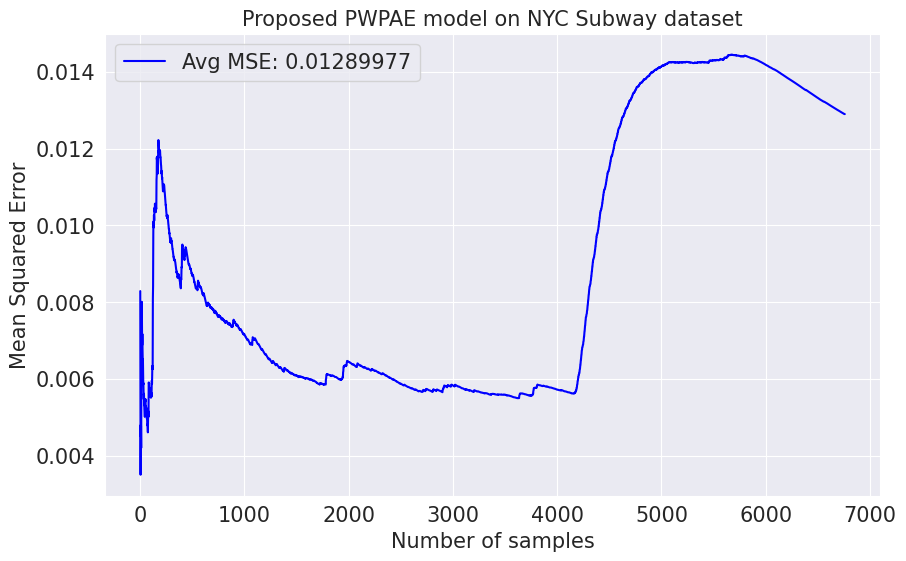

In [49]:
name = "Proposed PWPAE model"

t, m = PWPAE_Reg(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)

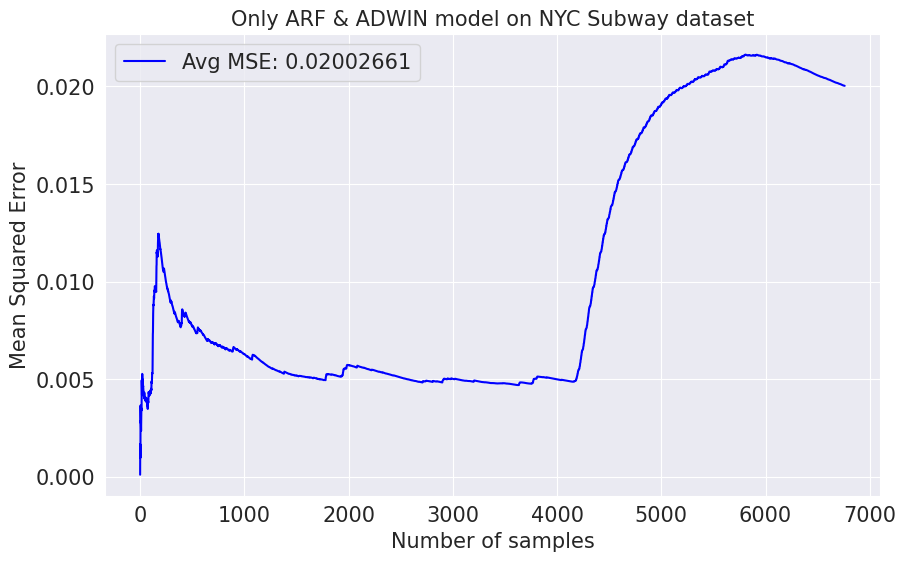

In [27]:
name = "Only ARF & ADWIN model"

t, m = PWPAE_Reg_ARF_ADWIN(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)


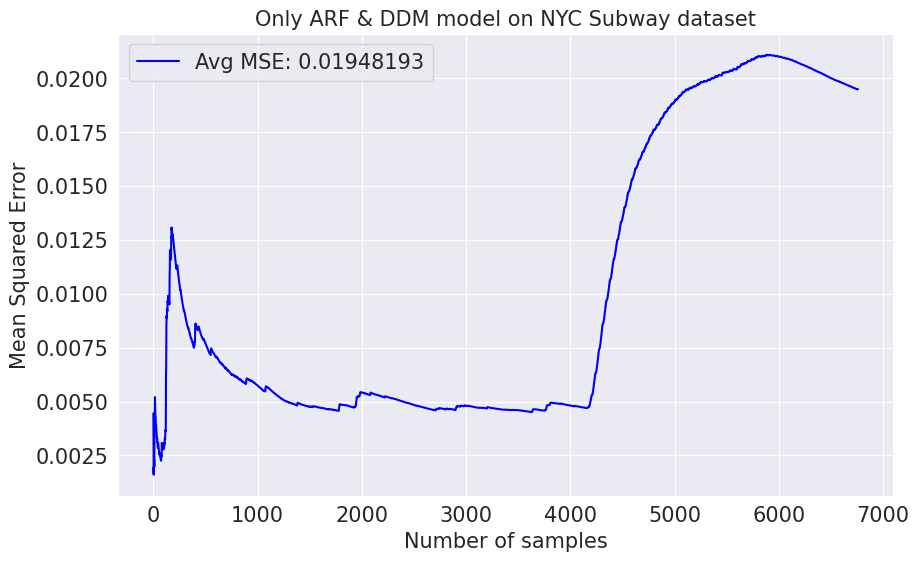

In [28]:
name = "Only ARF & DDM model"

t, m = PWPAE_Reg_ARF_DDM(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)

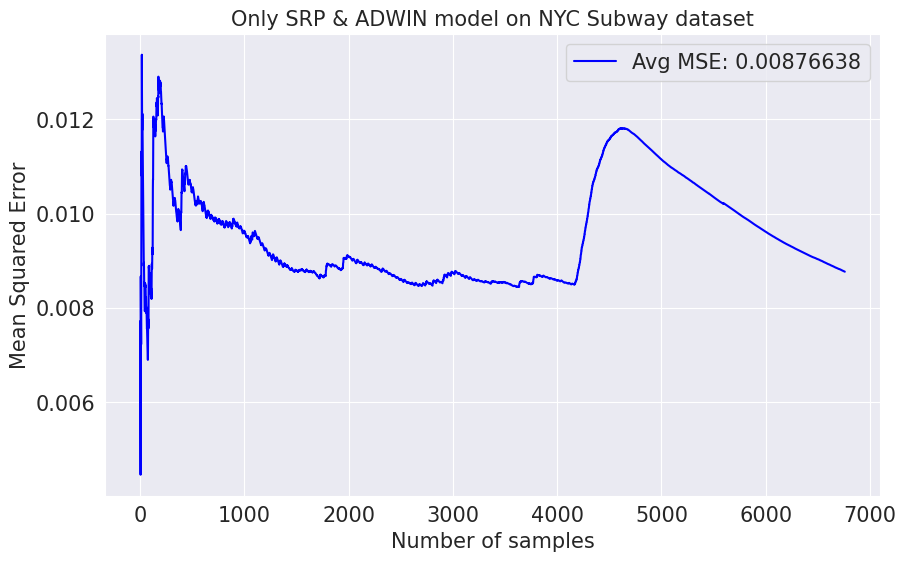

In [44]:
name = "Only SRP & ADWIN model"

t, m = PWPAE_Reg_SRP_ADWIN(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)

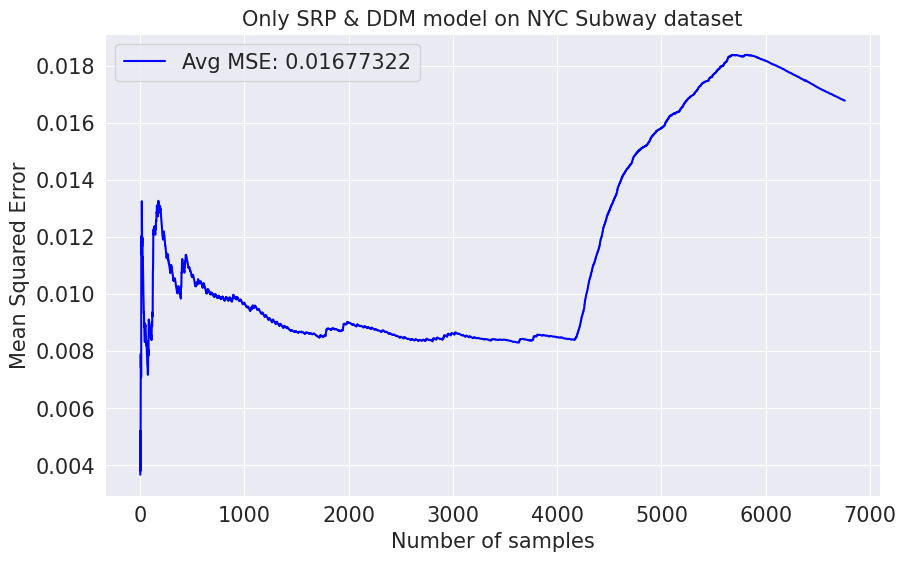

In [30]:

name = "Only SRP & DDM model"

t, m = PWPAE_Reg_SRP_DDM(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)

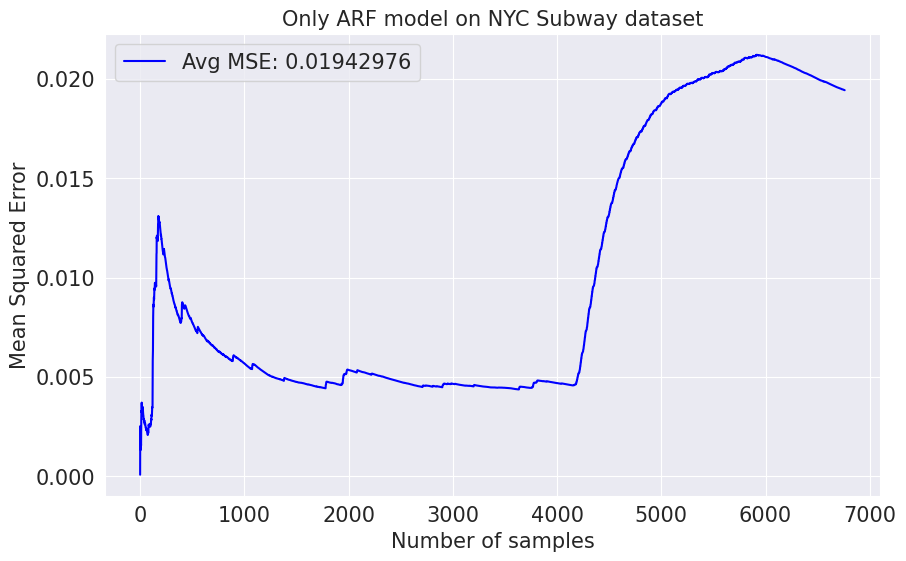

In [31]:
name = "Only ARF model"

t, m = PWPAE_Reg_ARF_None(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)

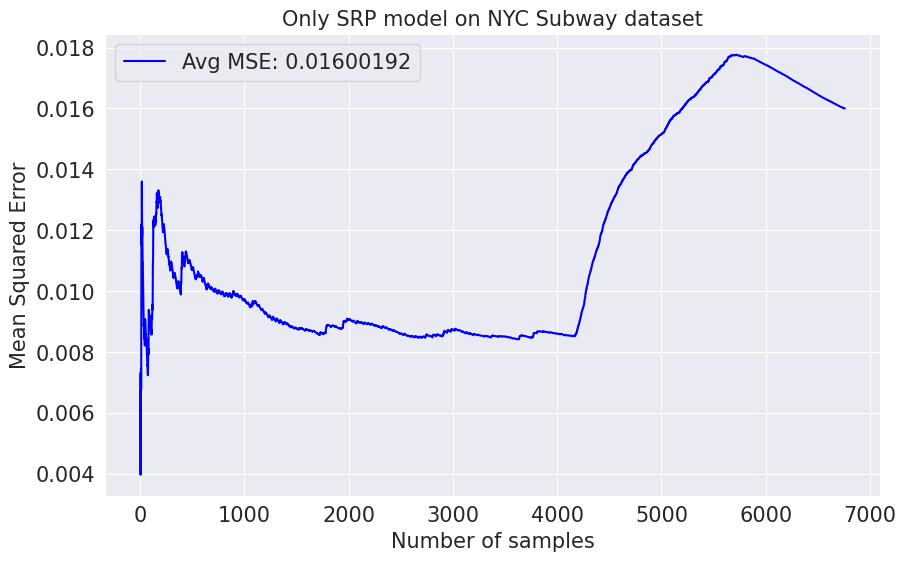

In [47]:
name = "Only SRP model"

t, m = PWPAE_SRP_None(X_train, y_train, X_stream, y_stream)
acc_fig(t, m, name)